In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 100. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 15. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(14401,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_GPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((13964,), (13964,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tc_at_constellation=True, 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

# response_kwargs_GPU_like = dict(
#     modes=[(2,2)], 
#     tc_at_constellation=True, 
#     tmin=t_start / DAY, # start time in day 
#     tmax=t_end / DAY, # end time in day  
#     TDIGeneration="2nd", # "1st" or "2nd"
#     optimal_combination=True, # True for AET, False for XYZ 
#     output_by_mode=False, 
#     interpolation=False,
# )

## Set parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [t_start/DAY+3., t_end/DAY-1.] 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 1.03000000e+02,  1.04000000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

## Set noise model

In [6]:
# arm_time = (t_start + t_end) / 2.
arm_time = np.mean(tc_prior) * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 13964), (13964, 3, 3))

## Data generation 

In [7]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 926687.7962499231
mass_ratio : 0.9567633432230952
spin_1z : 0.6040205824800265
spin_2z : 0.27947811560254954
coalescence_time : 103.64414519273659
coalescence_phase : 1.979442824073529
luminosity_distance : 16437.176005667454
inclination : 1.5758165619386904
longitude : 5.491269381236489
latitude : 0.5612559723434931
psi : 0.7337903434016219
optimal SNR: 3342.678274604042


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

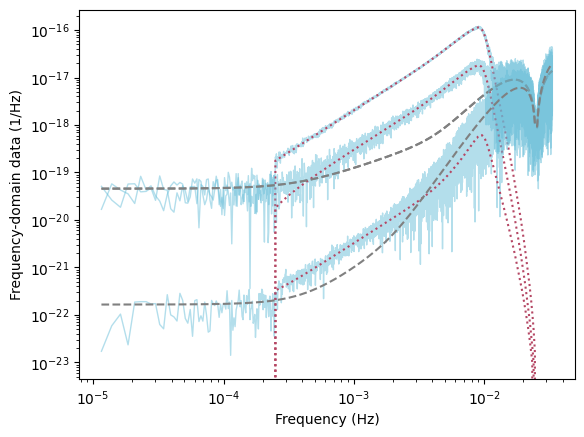

In [8]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [9]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    # response_parameters=response_kwargs_GPU_like, 
    response_parameters=response_kwargs_GPU,
    use_gpu=True,
)

### compare $\mathcal{F}$-stat and likelihood around truths

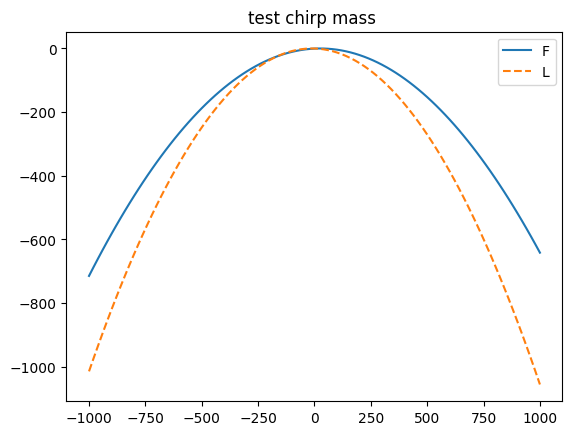

In [10]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test chirp mass ")
plt.legend()

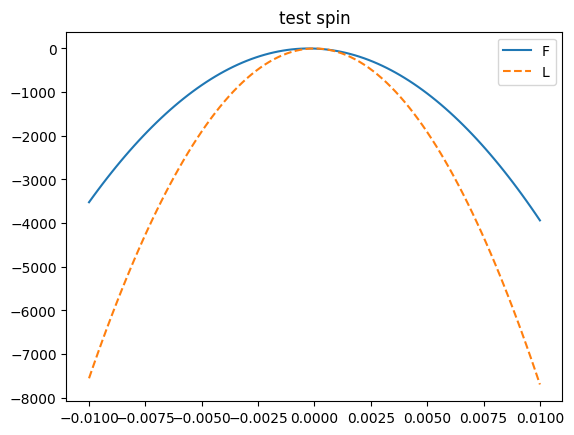

In [11]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.01, 0.01, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test spin")
plt.legend()

max F point = 103.64414519273659
max L point = 103.64414519273659
deviation = 0.0


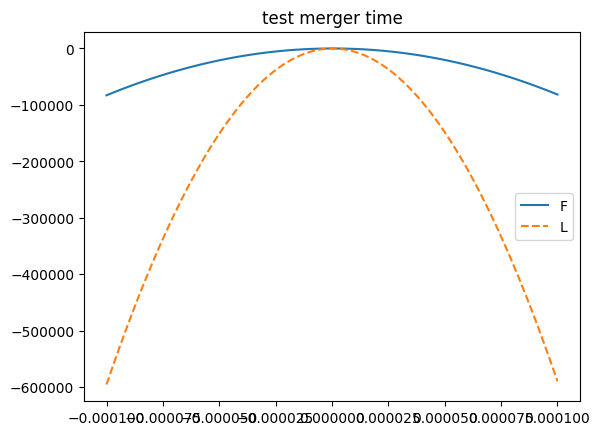

In [12]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-1e-4, 1e-4, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test merger time")

tc_best_F = test_int_params["coalescence_time"][np.argmax(test_F)]
tc_best_L = test_params["coalescence_time"][np.argmax(test_L)]
print("max F point =", tc_best_F)
print("max L point =", tc_best_L)
print("deviation =", tc_best_L - tc_best_F)
plt.legend()

max F point = 5.491269381236489
max L point = 5.491269381236489
deviation = 0.0


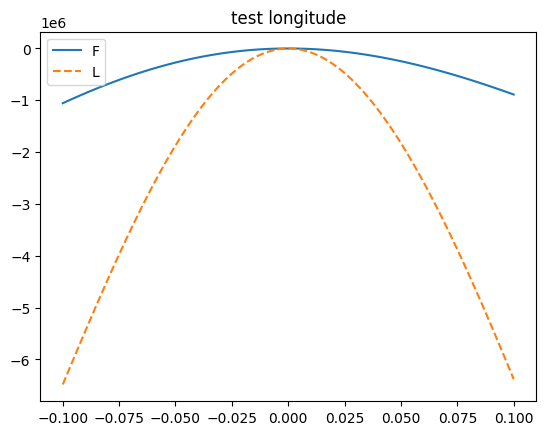

In [13]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["longitude"] = mbhb_parameters["longitude"] + np.linspace(-1e-1, 1e-1, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["longitude"] = test_int_params["longitude"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["longitude"] - mbhb_parameters["longitude"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["longitude"] - mbhb_parameters["longitude"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test longitude")

tc_best_F = test_int_params["longitude"][np.argmax(test_F)]
tc_best_L = test_params["longitude"][np.argmax(test_L)]
print("max F point =", tc_best_F)
print("max L point =", tc_best_L)
print("deviation =", tc_best_L - tc_best_F)
plt.legend()

## Optimize from priors

In [ ]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-8,
    atol=1e-10,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    vectorized=True,
)
print(DE_result)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


### reconstruct parameters and waveforms 

In [ ]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

# searched_wf = Fstat.calculate_Fstat_vectorized(
#     intrinsic_parameters=searched_int_params, 
#     return_recovered_wave=True
# )[:, 0, :]

searched_wf = FDTDI_GPU.Response(
    searched_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

print("parameter name | difference")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]))

parameter name | difference
chirp_mass 283.9867337886244
mass_ratio 0.0023813501244495106
spin_1z 0.0036973211597235434
spin_2z 0.002400709185133243
coalescence_time 0.0020313662355988527
longitude 0.35910391203576375
latitude 0.15404639311493423
luminosity_distance 2285.3210719570816
inclination 0.8146172218421726
psi 1.9258655290950764
coalescence_phase 3.2607251723642623


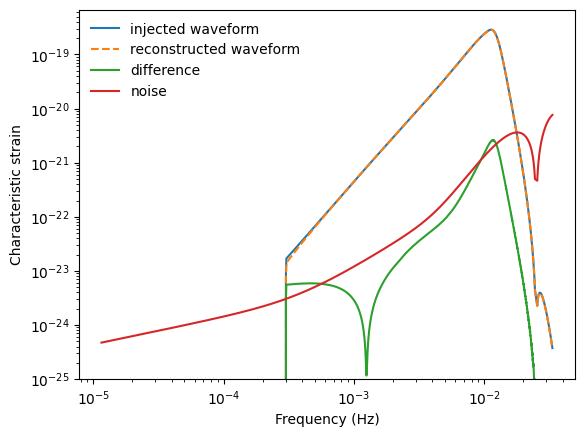

In [ ]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-", label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [ ]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 200.98686534405965,
 'mass_ratio': 0.013516910513647685,
 'spin_1z': 0.05650208002426072,
 'spin_2z': 0.08809735955878746,
 'coalescence_time': 0.00011714667368713507,
 'coalescence_phase': 0.10223152936965256,
 'luminosity_distance': 6746.667088495119,
 'inclination': 0.13192594619844855,
 'longitude': 0.020887645839066778,
 'latitude': 0.063213431578885,
 'psi': 0.023507104421707982}

In [ ]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 283.9867337886244 200.98686534405965 1.4129616544965826
mass_ratio 0.0023813501244495106 0.013516910513647685 0.17617562253187377
spin_1z 0.0036973211597235434 0.05650208002426072 0.06543690352879039
spin_2z 0.002400709185133243 0.08809735955878746 0.02725063721723972
coalescence_time 0.0020313662355988527 0.00011714667368713507 17.34036632592783
longitude 0.35910391203576375 0.020887645839066778 17.192167791552706
latitude 0.15404639311493423 0.063213431578885 2.4369250215865503
luminosity_distance 2285.3210719570816 6746.667088495119 0.3387333392889903
inclination 0.8146172218421726 0.13192594619844855 6.174806740569373
psi 1.9258655290950764 0.023507104421707982 81.9269568274265
coalescence_phase 3.2607251723642623 0.10223152936965256 31.895494398543242


## The PE phase

In [ ]:
# Like.prepare_het_log_like(
#     base_parameters=ParamDict2ParamArr(searched_params), 
#     # base_waveform=searched_wf
#     ) 

In [ ]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [ ]:
truths = np.array(ParamDict2ParamArr(searched_params)) # actually the searched values 
ground_truths = np.array(ParamDict2ParamArr(mbhb_parameters))
labels = np.array(list(mbhb_parameters.keys()))
fim_range = []
for par in labels:
    if par in ["chirp_mass", "luminosity_distance"]:
        ran = FIM.param_errors[par] / searched_params[par] / np.log(10.) # lg value 
    else:
        ran = FIM.param_errors[par] 
    fim_range.append(ran)
fim_range = np.array(fim_range) * 10. # ~10 sigmas, NOTE that not all of the priors are decided by fisher 

for idx, par in enumerate(labels):
    print(par, truths[idx], fim_range[idx])

chirp_mass 5.838047652183737 0.0012673726651265553
mass_ratio 0.6703656034623999 0.13516910513647684
spin_1z 0.3503517448603942 0.5650208002426073
spin_2z 0.29014791437998577 0.8809735955878746
coalescence_time 103.54712894748866 0.0011714667368713507
coalescence_phase 6.209581099926881 1.0223152936965256
luminosity_distance 4.420657715356067 1.112284477716567
inclination 0.3671771334698319 1.3192594619844855
longitude 1.3690178168879714 0.20887645839066776
latitude -0.024662090482738264 0.6321343157888499
psi 3.0853901523805285 0.2350710442170798


In [ ]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 1000 # number of random walkers, more walkers can be used since heterodyned likelihood requires much less vRAM, 400 is a quite large number for this task 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set a narrower prior for the instrinsic parameters, since heterodyned likelihood must be based on an initial estimation 
lim_lgMc = [truths[0] - fim_range[0], truths[0] + fim_range[0]]
lim_q = [max(0.1, truths[1] - fim_range[1]), min(1., truths[1] + fim_range[1])]
lim_chiz1 = [max(-0.9, truths[2] - fim_range[2]), min(0.9, truths[2] + fim_range[2])]
lim_chiz2 = [max(-0.9, truths[3] - fim_range[3]), min(0.9, truths[3] + fim_range[3])]
lim_tc = [truths[4] - max(0.01, fim_range[4]), truths[4] + max(0.01, fim_range[4])] # empirical 
lim_phic = [0, TWOPI]
lim_lgD = [max(lgdl_prior[0], truths[6]-fim_range[6]), min(lgdl_prior[1], truths[6]+fim_range[6])]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
# start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_lims = lims.copy()
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[  5.83678028,   5.83931502],
        [  0.5351965 ,   0.80553471],
        [ -0.21466906,   0.9       ],
        [ -0.59082568,   0.9       ],
        [103.53712895, 103.55712895],
        [  0.        ,   6.28318531],
        [  4.        ,   5.        ],
        [ -1.        ,   1.        ],
        [  0.        ,   6.28318531],
        [ -1.        ,   1.        ],
        [  0.        ,   3.14159265]]),
 array([[  5.83678028,   5.83931502],
        [  0.5351965 ,   0.80553471],
        [ -0.21466906,   0.9       ],
        [ -0.59082568,   0.9       ],
        [103.53712895, 103.55712895],
        [  0.        ,   6.28318531],
        [  4.        ,   5.        ],
        [ -1.        ,   1.        ],
        [  0.        ,   6.28318531],
        [ -1.        ,   1.        ],
        [  0.        ,   3.14159265]]))

In [ ]:
((lims.T - ground_truths)[0] < 0.).all(), ((lims.T - ground_truths)[1] > 0.).all()

(True, True)

In [ ]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    return Like.full_log_like_vectorized(np.transpose(params))
    # return Like.het_log_like_vectorized(np.transpose(params))

In [ ]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [ ]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(150000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 1000, 11)


 14%|█▍        | 21692/150000 [42:45<3:56:34,  9.04it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_17345/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 382, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1164, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 975, in TransferFunction
    zero_inds = self.xp.where(t < tmin * DAY)
  File "/hom

eryn: Exception while calling your likelihood function:
  args added: [array([[ 5.83931502,  0.53519661,  0.9       , ...,  3.18197497,
        -0.47844187,  1.81227394],
       [ 5.83931502,  0.53519659,  0.89999999, ...,  3.18214113,
        -0.47844815,  0.71327035],
       [ 5.83931502,  0.53519652,  0.89999998, ...,  3.18209909,
        -0.47845647,  1.93342418],
       ...,
       [ 5.83781576,  0.59258398,  0.30228705, ...,  2.78123227,
         0.37200461,  0.80233878],
       [ 5.83896435,  0.53701165,  0.70676147, ...,  4.36789339,
         0.00671054,  1.21295119],
       [ 5.83735681,  0.6183927 ,  0.38610309, ...,  3.54047003,
        -0.13285915,  2.14013115]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# # resume run after the run is stopped 
# thin_by =100
# burn = 0
# nsteps = int(100000 / thin_by) # this should be far more than enough 

# out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

  4%|▍         | 4095/100000 [1:09:06<26:36:44,  1.00it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_8610/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 376, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1148, in Response
    results[self.xp.abs(results)<1e-23]=0.
  File "cupy/_core/core.pyx", line 1641, in cupy._core.core._ndarray_base.__setitem__
  File "cupy/_core/_routines_indexing.pyx", line 51, in cupy._core._routines_indexing._ndarray_setitem
  File "cupy/_core/_routines_indexing.pyx", line 1003, in cupy._core._routines_index

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.13034413,  0.59039477, -0.30162392, ...,  4.35254556,
        -0.55723331,  1.61479995],
       [ 6.13205732,  0.5677826 , -0.13613928, ...,  4.52881696,
        -0.54829891,  1.59342131],
       [ 6.13227933,  0.56786834, -0.10910596, ...,  4.63250165,
        -0.65739775,  1.42409828],
       ...,
       [ 6.13430424,  0.53243933, -0.68857144, ...,  4.18385244,
         0.09106388,  0.7670817 ],
       [ 6.13554145,  0.65018968, -0.57997314, ...,  0.31655064,
        -0.77354668,  1.68829248],
       [ 6.13381079,  0.52236707,  0.23064524, ...,  1.37719796,
        -0.69901723,  2.80645318]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

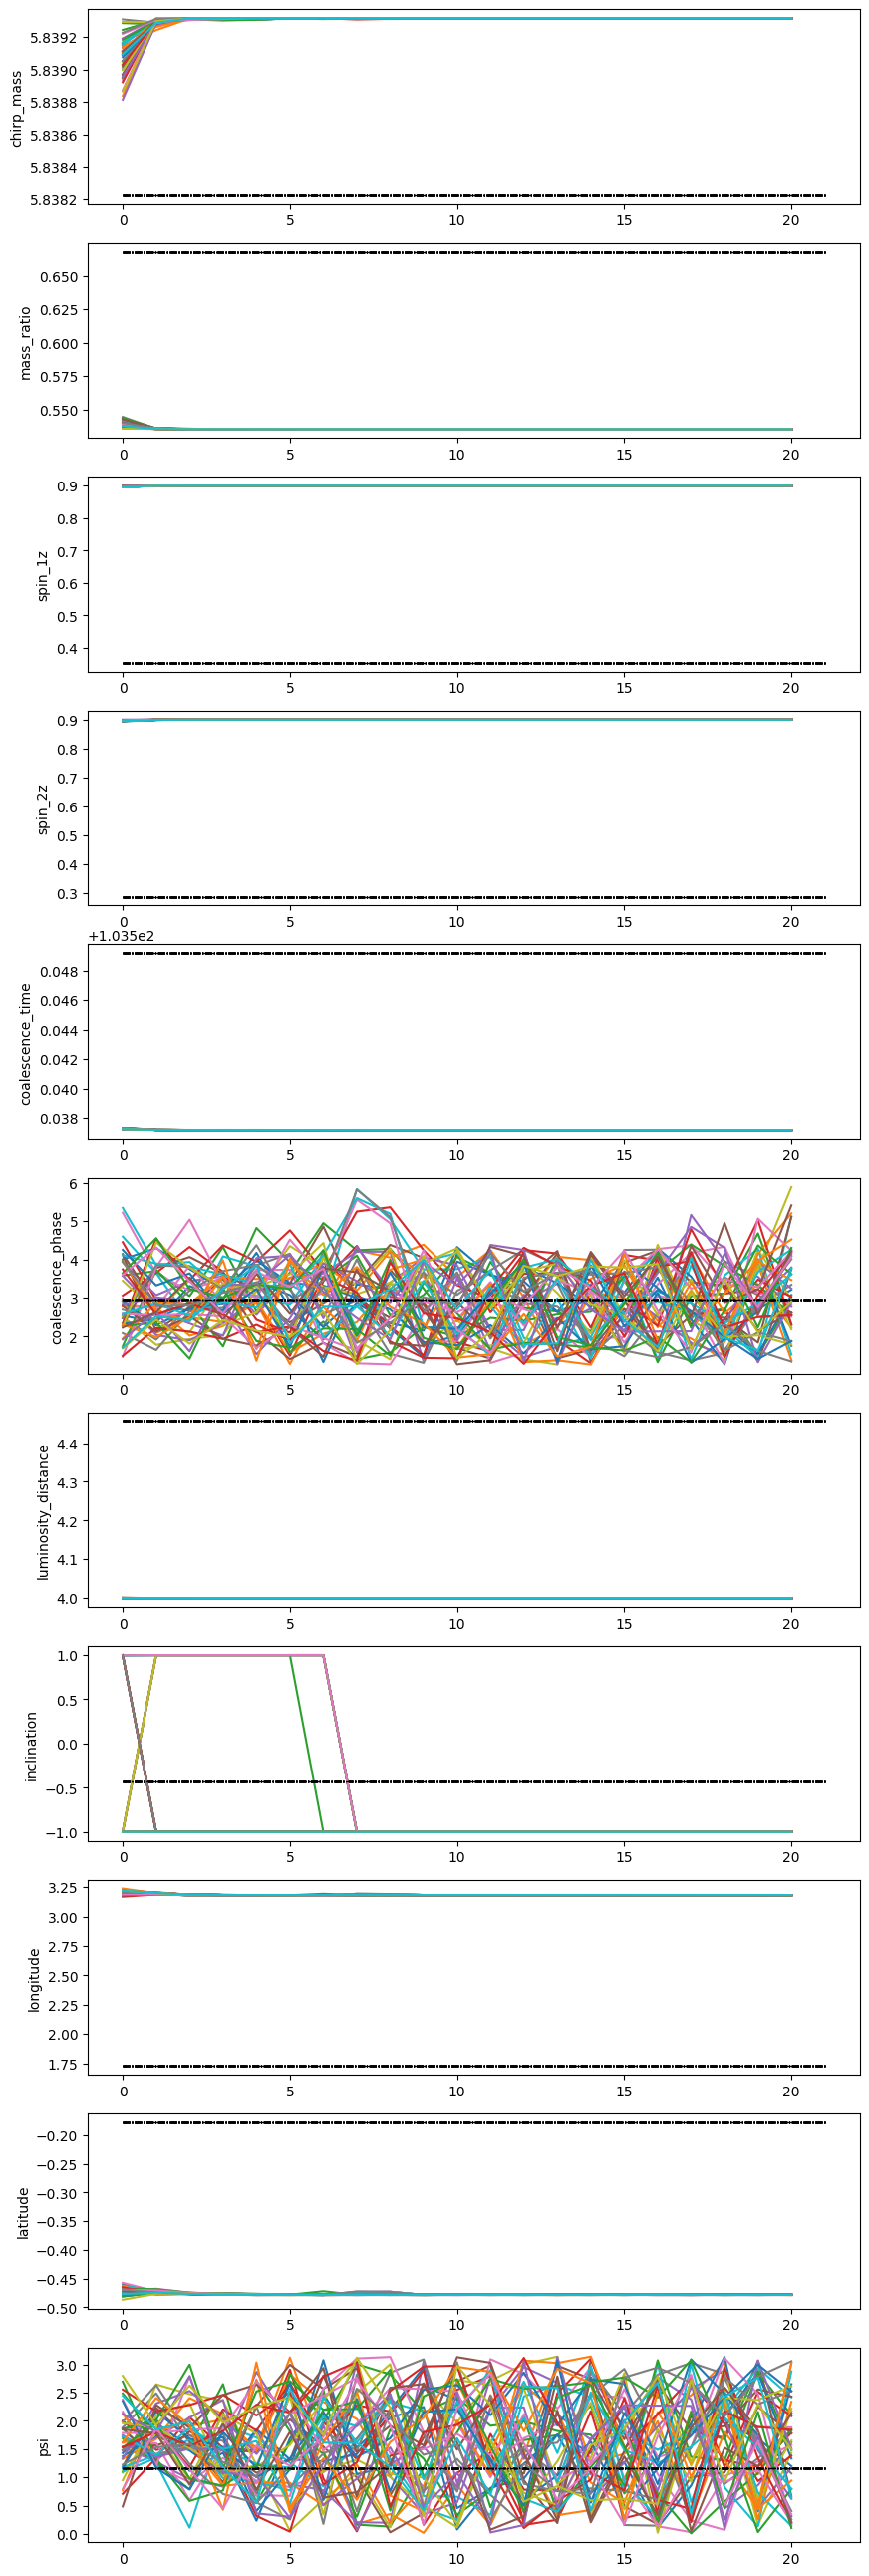

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(50): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(ground_truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_het.jpg", dpi=360)

sample shape: (15000, 11)


<Figure size 640x480 with 0 Axes>

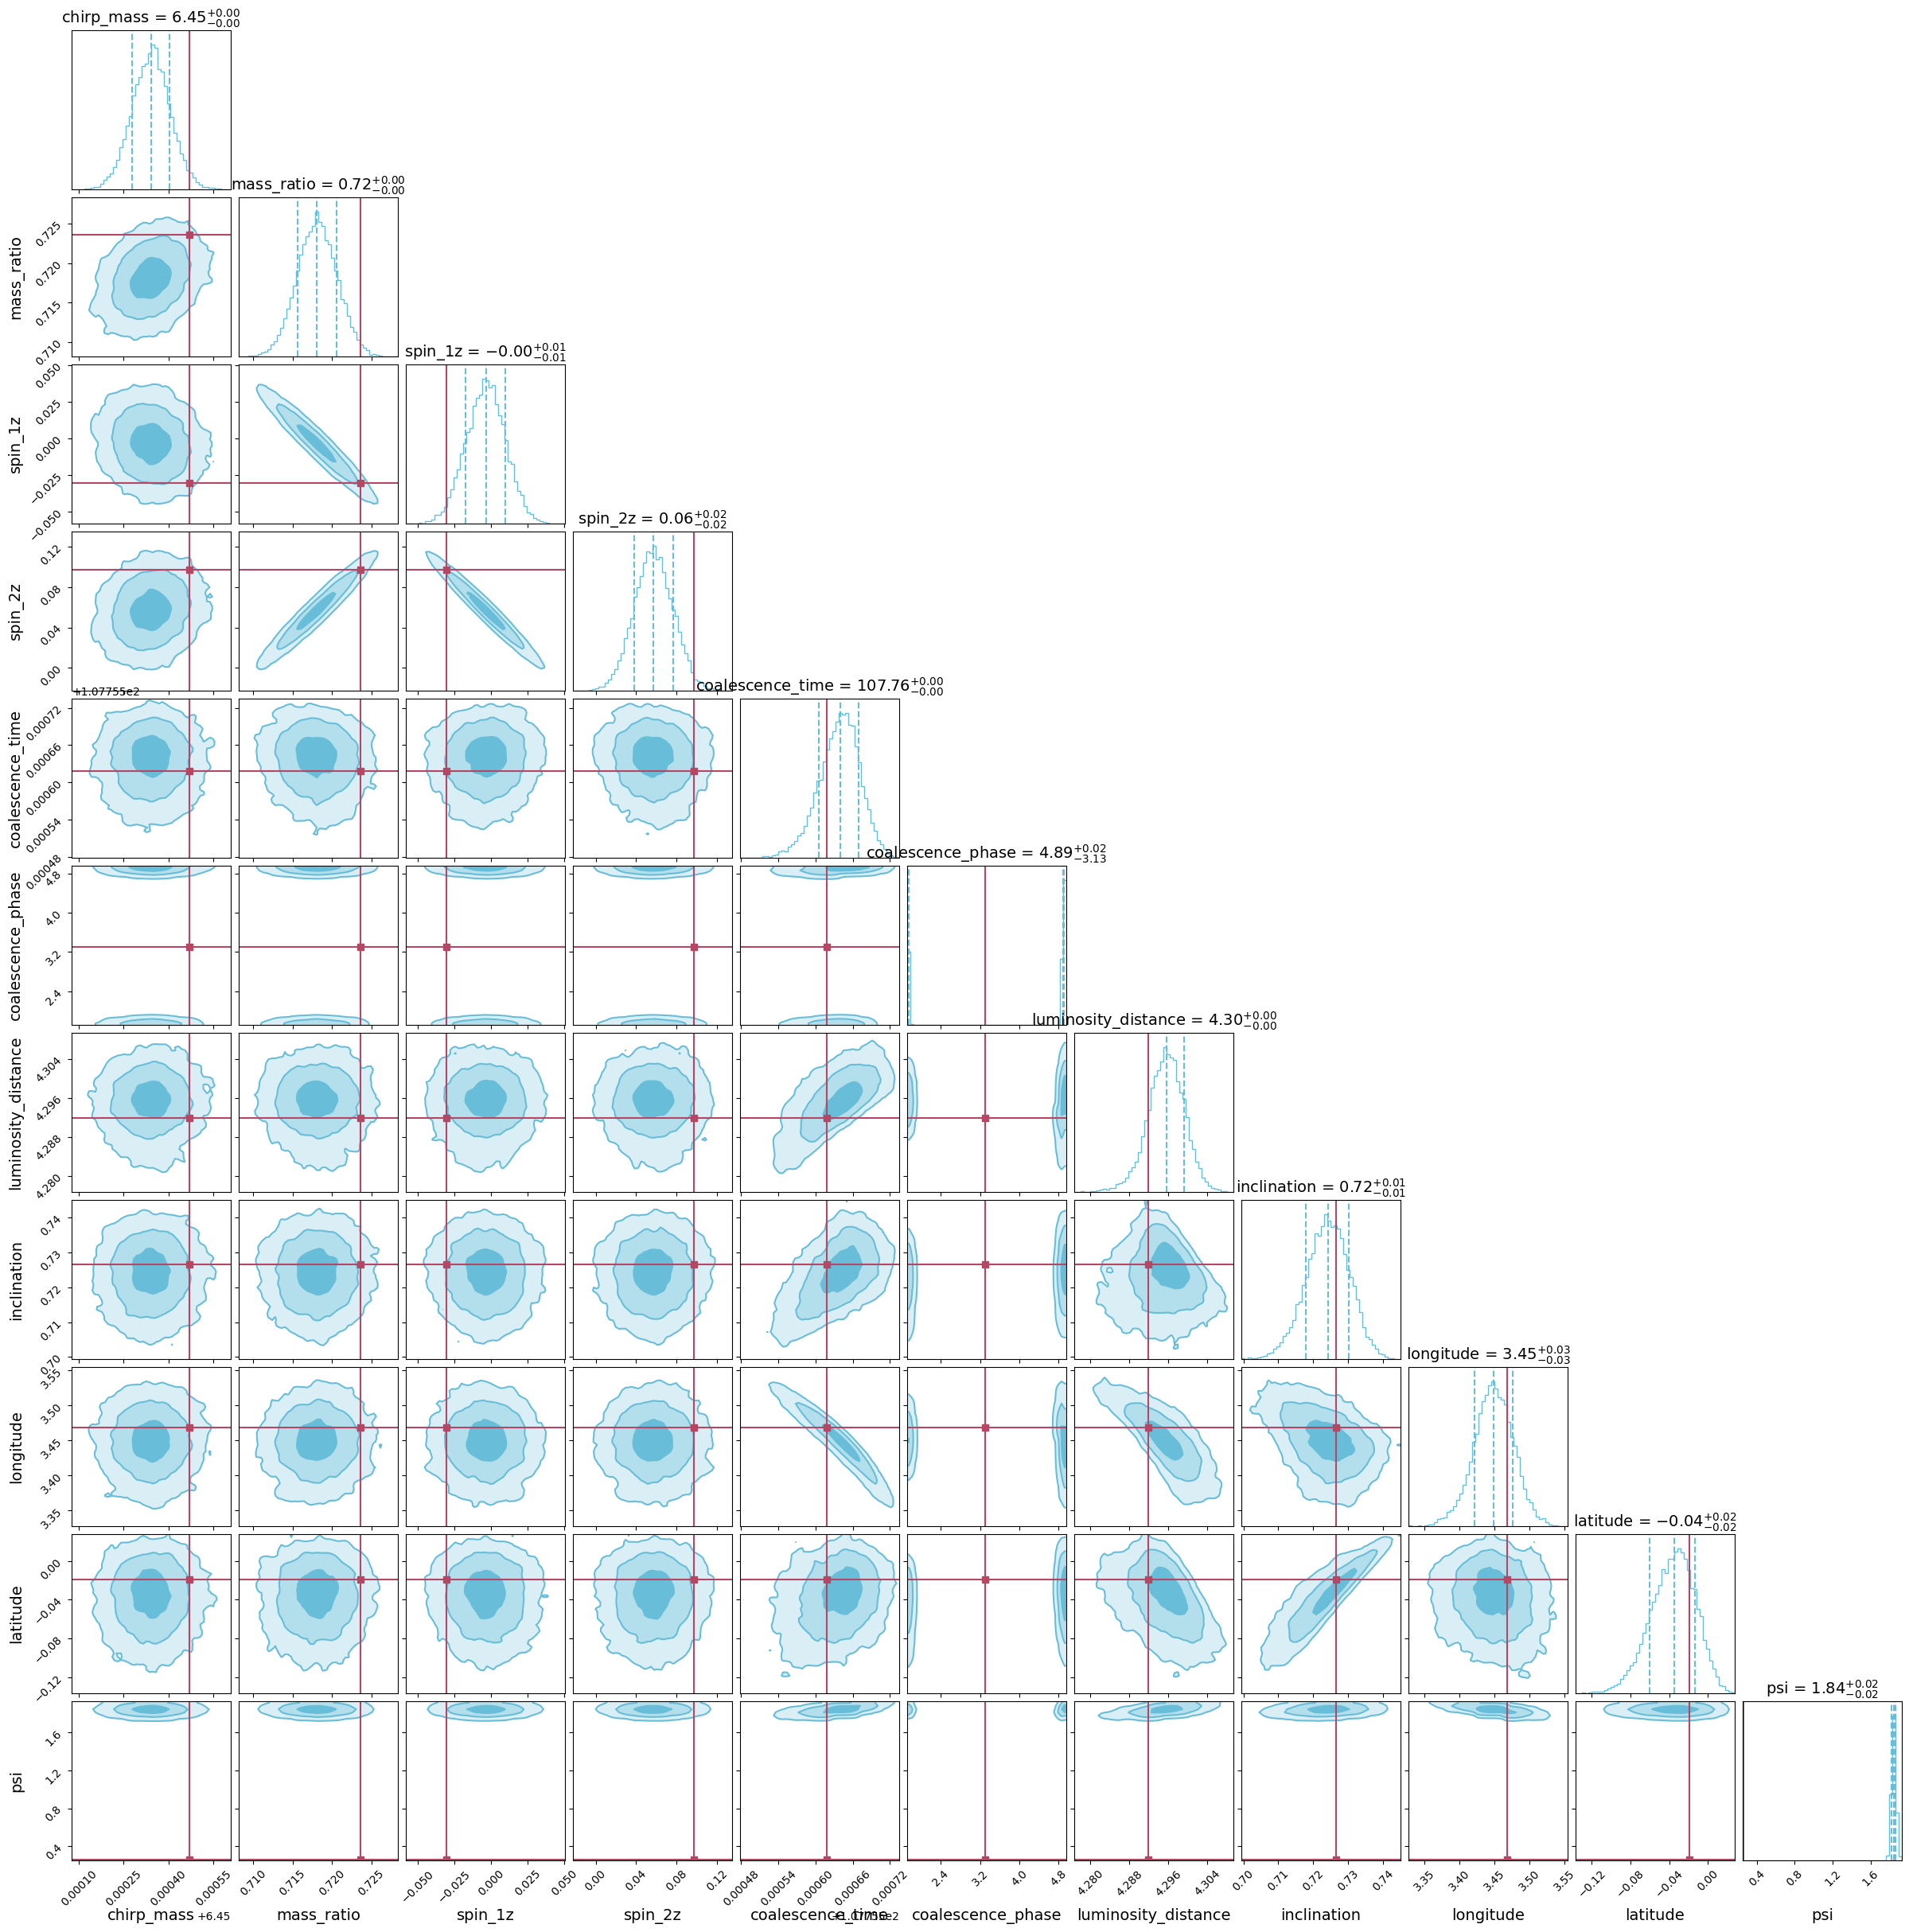

In [ ]:
burnin=200
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=ground_truths, truth_color=RED,
    # truths=truths, truth_color=GREEN1, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_het.jpg", dpi=360)
# np.save("chain_het.npy", samp)